In [26]:
from pathlib import Path
from typing import List, Dict
import yaml
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SUPPORTED_FORMATS = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif", ".webp"]

In [3]:
def scan_images_metadata(root_dir: str) -> List[Dict]:
    image_files = []
    root = Path(root_dir)

    for filepath in root.rglob("*"):
        if filepath.suffix.lower() in SUPPORTED_FORMATS:
            try:
                stat = filepath.stat()
                image_files.append({
                    "path": str(filepath.resolve()),
                    "name": filepath.name,
                    "ext": filepath.suffix.lower(),
                    "size": stat.st_size,
                    "modified": stat.st_mtime,
                })
            except Exception as e:
                print(f"Skipping {filepath}: {e}")
    
    return image_files

In [9]:
# Load the gallery path from config.yaml
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

SOURCE_DIR = Path(config["gallery_path"])

In [11]:
photos = scan_images_metadata(SOURCE_DIR)
print(f"Found {len(photos)} images")

Found 1826 images


In [12]:
df = pd.DataFrame(photos)
df.to_parquet("../data/scanned_images_metadata.parquet")
df.head()

,path,name,ext,size,modified
0,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050125000_iOS.jpg,.jpg,179880,1.526620e+09
1,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050225000_iOS.jpg,.jpg,229475,1.526620e+09
2,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050330000_iOS.jpg,.jpg,253318,1.526620e+09
3,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050359000_iOS.jpg,.jpg,128273,1.526620e+09
4,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050416000_iOS.jpg,.jpg,214668,1.526620e+09


In [13]:
total_size_bytes = df['size'].sum()
total_size_gb = total_size_bytes / (1024 ** 3)
print(f"Gallery size (on disk): {total_size_gb:.2f} GB")

Gallery size (on disk): 2.90 GB


> - ### Preprocess sample images

In [18]:
def preprocess_image(path: str, size=(224, 224)) -> np.ndarray:
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize(size)
        return np.array(img)
    except Exception as e:
        print(f"Failed to preprocess {path}: {e}")
        return None

In [19]:
def preprocess_batch(file_list: List[str], size=(224, 224)) -> List[np.ndarray]:
    results = []
    for path in file_list:
        preprocessed = preprocess_image(path, size)
        if preprocessed is not None:
            results.append(preprocessed)
    return results

In [49]:
def show_images(images, columns=5, size=(15, 5)):
    n_images = len(images)
    rows = (n_images + columns - 1) // columns
    plt.figure(figsize=size)
    
    for i, img in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [20]:
# Load your previously scanned metadata
df = pd.read_parquet("../data/scanned_images_metadata.parquet")
df = df[df["size"] > 0].copy()
df.head()

,path,name,ext,size,modified
0,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050125000_iOS.jpg,.jpg,179880,1.526620e+09
1,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050225000_iOS.jpg,.jpg,229475,1.526620e+09
2,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050330000_iOS.jpg,.jpg,253318,1.526620e+09
3,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050359000_iOS.jpg,.jpg,128273,1.526620e+09
4,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,20180518_050416000_iOS.jpg,.jpg,214668,1.526620e+09


In [44]:
# Select a small batch to test
sample_paths = df["path"].head(100).tolist()

images = preprocess_batch(sample_paths)
print(f"Successfully preprocessed {len(images)} images")

Successfully preprocessed 100 images


C:\Users\ynany\AppData\Local\Temp\ipykernel_27328\2170626843.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


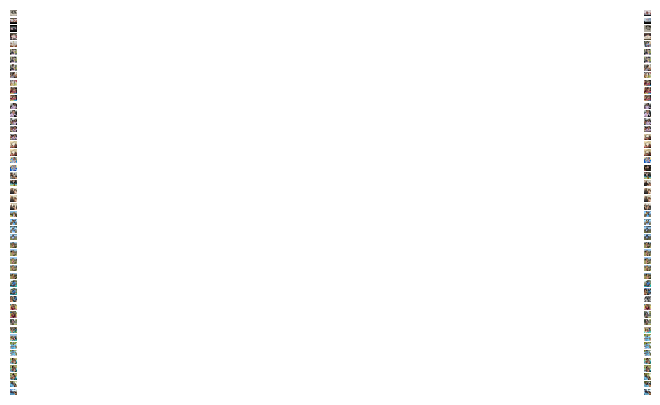

In [50]:
show_images(images, columns=2)

> - ### Generate Embeddings with CLIP

In [31]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
from tqdm import tqdm

In [60]:
from collections import defaultdict
import shutil

In [33]:
# Load pre-trained CLIP model & processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

c:\users\ynany\appdata\local\programs\python\python38\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ynany\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [34]:
def get_image_embeddings(images: list) -> torch.Tensor:
    # Convert list of numpy arrays to list of PIL Images
    pil_images = [Image.fromarray(img) for img in images]
    
    # Preprocess and tokenize
    inputs = processor(images=pil_images, return_tensors="pt", padding=True).to(device)
    
    # Get image embeddings
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    
    return outputs.cpu()

In [51]:
embeddings = get_image_embeddings(images)
print(f"Embedding shape: {embeddings.shape}")

Embedding shape: torch.Size([100, 512])


In [52]:
def compute_similarity_matrix(embeddings: torch.Tensor) -> np.ndarray:
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
    sim_matrix = embeddings @ embeddings.T
    return sim_matrix.cpu().numpy()

In [90]:
def find_duplicate_pairs(sim_matrix: np.ndarray, paths: list, threshold) -> pd.DataFrame:
    n = sim_matrix.shape[0]
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            sim_score = sim_matrix[i, j]
            if sim_score >= threshold:
                pairs.append({
                    "img1": paths[i],
                    "img2": paths[j],
                    "similarity": sim_score
                })

    return pd.DataFrame(pairs)

In [93]:
sim_matrix = compute_similarity_matrix(embeddings)
duplicate_df = find_duplicate_pairs(sim_matrix, sample_paths, threshold=0.98)
print(duplicate_df.shape)

(11, 3)


In [94]:
duplicate_df

,img1,img2,similarity
0,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.984280
1,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.986520
2,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.984405
3,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.987386
4,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.995920
5,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.981924
6,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.991665
7,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.984932
8,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.984574
9,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,C:\Users\ynany\OneDrive\Desktop\Pictures and V...,0.982485


In [95]:
def group_duplicates(duplicate_df):
    parent = {}

    def find(x):
        if parent.get(x, x) != x:
            parent[x] = find(parent[x])
        return parent.get(x, x)

    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[py] = px

    # Create union-find structure
    for _, row in duplicate_df.iterrows():
        union(row["img1"], row["img2"])

    # Group images by their root parent
    groups = defaultdict(list)
    for img in set(duplicate_df["img1"]).union(duplicate_df["img2"]):
        root = find(img)
        groups[root].append(img)

    return list(groups.values())


In [96]:
duplicate_groups = group_duplicates(duplicate_df)
print(f"Found {len(duplicate_groups)} duplicate groups")

Found 8 duplicate groups


In [97]:
# Show group sizes
total=0
for i, group in enumerate(duplicate_groups):
    total+=len(group)
    print(f"Group {i+1}: {len(group)} images")

Group 1: 2 images
Group 2: 2 images
Group 3: 2 images
Group 4: 2 images
Group 5: 3 images
Group 6: 2 images
Group 7: 3 images
Group 8: 2 images


In [98]:
total

18

In [99]:
def show_image_group(image_paths, columns=5, figsize=(15, 5)):
    n = len(image_paths)
    rows = (n + columns - 1) // columns
    plt.figure(figsize=figsize)
    
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(path), fontsize=8)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ynany\\OneDrive\\Desktop\\Pictures and Videos\\Pictures\\Camera Roll\\2020\\05\\20200530_151236965_iOS.jpg'

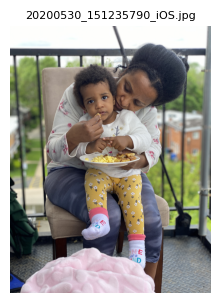

In [100]:
for g in duplicate_groups:
    show_image_group(g)

> - ### Move or Copy Duplicates

In [87]:
def move_or_copy_duplicates(duplicate_groups, action="copy", output_dir="../data/sample_duplicates"):
    
    assert action in ["copy", "move"], "Action must be 'copy' or 'move'"
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    moved_files = []

    for group in duplicate_groups:
        if len(group) < 2:
            continue

        keep = group[0]
        to_move = group[1:]

        for path in to_move:
            src = Path(path)
            filename = src.name
            dst = output_dir / filename

            # Avoids overwriting
            i = 1
            while dst.exists():
                dst = output_dir / f"{src.stem}_{i}{src.suffix}"
                i += 1

            try:
                if action == "copy":
                    shutil.copy2(src, dst)
                else:
                    shutil.move(src, dst)

                moved_files.append({"original": str(src), "duplicate": str(dst)})
            except Exception as e:
                print(f"Failed to {action} {src} → {dst}: {e}")

    return moved_files

In [89]:
log = move_or_copy_duplicates(duplicate_groups, action="move", output_dir="../data/sample_duplicates")
len(log)

10